In [1]:
import sys
sys.path.append("../scripts")
import numpy as np
import fit_psf
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = "nearest"

# Load data from files

In [3]:
from astropy.io import fits
from pathlib import Path

In [4]:
datapath = Path.cwd().parent / "data"

Get the synthetic PSF that is 512 pixels and used the O3 star spectrum

In [5]:
psf = fit_psf.OversampledPSF(
    fits.open(datapath / "psf-o3v-512-0000-0000-nircam-f090w.fits")["OVERDIST"].data,
    oversample = 4,
)

Now get the target image that we want to fit

In [6]:
im = fit_psf.PixelImage(
    fits.open(datapath / "wr124-jwst-nircam-2022-f090w.fits")["SCI"].data
)

In [7]:
x0, y0 = 2315.60, 2321.96

In [8]:
peak = fit_psf.Peak(im, x0, y0, psf)

In [9]:
peak.bg0, peak.bscale0

(0.7265795516967773, 296336.89778307534)

In [10]:
%%time
peak.reproject_order = "nearest-neighbor"
#peak.reproject_order = "bicubic"
#peak.reproject_order = "bilinear"
peak.update_model_image(peak.bscale0, x0, y0, peak.bg0, theta=0, smoothing=0)

CPU times: user 75.1 ms, sys: 45.1 ms, total: 120 ms
Wall time: 119 ms


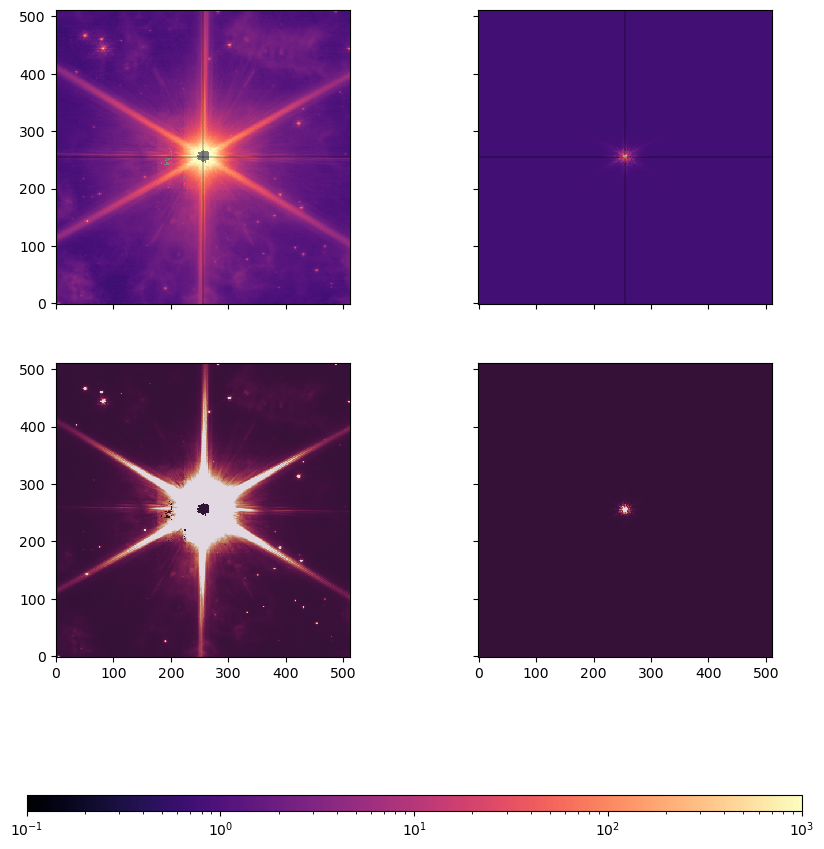

In [11]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 12))
norm = matplotlib.colors.LogNorm(vmin=0.1, vmax=1000.0)
cmap = matplotlib.cm.get_cmap("magma").copy()
cmap.set_bad("gray")
im = ax[0, 0].imshow(peak.obs_im, norm=norm, cmap=cmap)
ax[0, 1].imshow(peak.mod_im, norm=norm, cmap=cmap)
fig.colorbar(im, ax=ax, orientation="horizontal", aspect=50,)
for _ax in ax[0, :]:
    _ax.axhline(255.5, color="k", linewidth=0.3)
    _ax.axvline(255.5, color="k", linewidth=0.3)
vscale = 20
cmap = matplotlib.cm.get_cmap("twilight").copy()
cmap.set_bad("gray")
ax[1, 0].imshow(
    peak.obs_im, 
    vmin=-vscale, vmax=vscale, cmap=cmap)
ax[1, 1].imshow(
    peak.mod_im, 
    vmin=-vscale, vmax=vscale, cmap=cmap)

...;

In [12]:
np.percentile(peak.obs_im, 1), np.percentile(peak.mod_im, 1)

(0.7265795516967773, 0.7265795516967773)

In [13]:
np.max(peak.obs_im[peak.mask]), np.max(peak.mod_im[peak.mask])

(5483.3906, 5627.667073295694)

In [14]:
%%time
result = fit_psf.fit_peak(peak)

CPU times: user 896 ms, sys: 456 ms, total: 1.35 s
Wall time: 1.35 s


In [15]:
result

In [16]:
residual = np.zeros_like(peak.skycutout.data)
residual[peak.mask] = fit_psf.residual(result.params, peak)

AttributeError: 'Peak' object has no attribute 'psfskycutout'

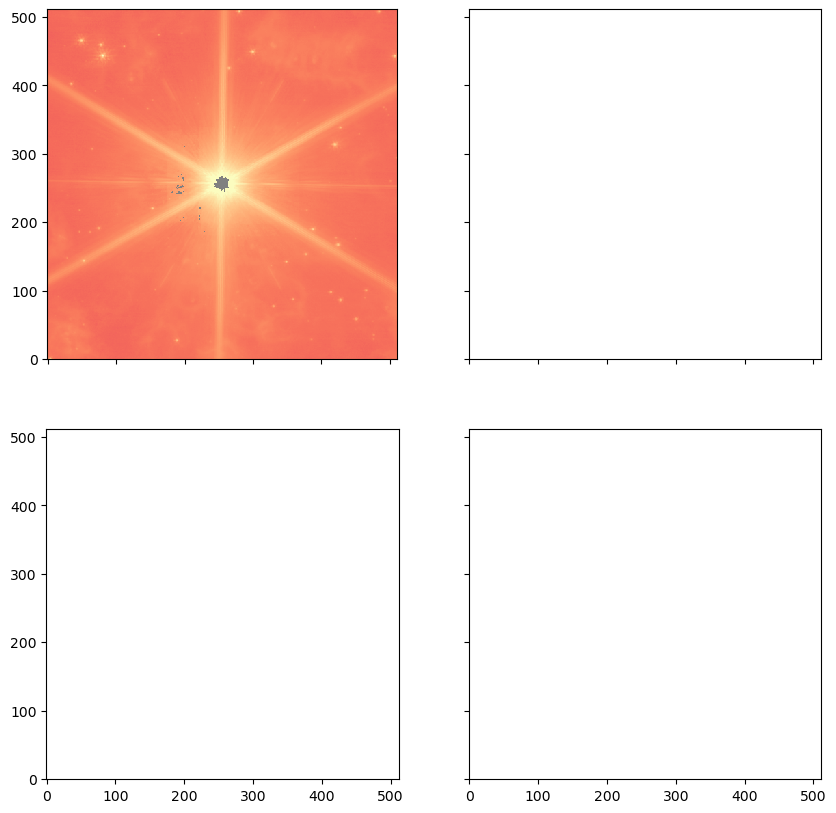

In [17]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
norm = matplotlib.colors.LogNorm(vmin=0.0, vmax=1000.0)
cmap = matplotlib.cm.get_cmap("magma").copy()
cmap.set_bad("gray")
ax[0, 0].imshow(peak.skycutout.data, norm=norm, cmap=cmap)
ax[0, 1].imshow(peak.psfskycutout, norm=norm, cmap=cmap)
for _ax in ax[0, :]:
    _ax.axhline(255.5, color="k", linewidth=0.3)
    _ax.axvline(255.5, color="k", linewidth=0.3)
vscale = 20
cmap = matplotlib.cm.get_cmap("twilight").copy()
cmap.set_bad("gray")
ax[1, 0].imshow(
    peak.skycutout.data, 
    vmin=-vscale, vmax=vscale, cmap=cmap)
ax[1, 1].imshow(
    peak.psfskycutout * result.init_values["bscale"] / peak.bscale, 
    vmin=-vscale, vmax=vscale, cmap=cmap)

...;

In [ ]:
result.init_values

In [ ]:
peak.bscale

In [ ]:
peak.skycutout.data[peak.mask].max()

In [ ]:
peak.psfskycutout[peak.mask].max()